## Multiclass classification of breast cancer patients - Notebook 2

In this notebook, I applied ensemble algorithm (XGBoost) and built a neural network model (Keras Sequential) to classify and predict the survival rate of patients with breast cancer.

### 1. Prepare Problem

In [1]:
# a) Load libraries
import pandas as pd
from pandas import set_option
from pandas import DataFrame

import numpy as np

import xgboost as xgb

import matplotlib.pyplot as plt

from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import Dropout

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import accuracy_score
from scikeras.wrappers import KerasClassifier

from xgboost import XGBClassifier

from pickle import dump

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

2023-01-20 00:30:31.677582: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-20 00:30:31.953240: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-20 00:30:31.953264: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-20 00:30:32.988225: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
# b) Load dataset
raw_data = pd.read_csv('METABRIC_RNA_Mutation.csv', header=0)
print(raw_data.shape)
print(raw_data.head(10))
print(raw_data.dtypes)

(1904, 693)
   patient_id  age_at_diagnosis type_of_breast_surgery    cancer_type  \
0           0             75.65             MASTECTOMY  Breast Cancer   
1           2             43.19      BREAST CONSERVING  Breast Cancer   
2           5             48.87             MASTECTOMY  Breast Cancer   
3           6             47.68             MASTECTOMY  Breast Cancer   
4           8             76.97             MASTECTOMY  Breast Cancer   
5          10             78.77             MASTECTOMY  Breast Cancer   
6          14             56.45      BREAST CONSERVING  Breast Cancer   
7          22             89.08      BREAST CONSERVING  Breast Cancer   
8          28             86.41      BREAST CONSERVING  Breast Cancer   
9          35             84.22             MASTECTOMY  Breast Cancer   

                        cancer_type_detailed cellularity  chemotherapy  \
0           Breast Invasive Ductal Carcinoma         NaN             0   
1           Breast Invasive Ductal C

/tmp/ipykernel_4697/1224547202.py:2: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('METABRIC_RNA_Mutation.csv', header=0)


There are 1904 attributes from 693 input fearures. One feature (death_from_cancer) is the output feature for classification.

### 2. Dataset summary

In [3]:
# a) Statistical summary
# print the statistical summary of some columns
pd.options.display.width = 100
pd.options.display.precision = 3
tempt = raw_data[0:10]
print(tempt.describe())

       patient_id  age_at_diagnosis  chemotherapy  cohort  neoplasm_histologic_grade  \
count      10.000            10.000        10.000    10.0                     10.000   
mean       13.000            68.729         0.400     1.0                      2.500   
std        11.681            17.713         0.516     0.0                      0.527   
min         0.000            43.190         0.000     1.0                      2.000   
25%         5.250            50.765         0.000     1.0                      2.000   
50%         9.000            76.310         0.000     1.0                      2.500   
75%        20.000            82.858         1.000     1.0                      3.000   
max        35.000            89.080         1.000     1.0                      3.000   

       hormone_therapy  lymph_nodes_examined_positive  mutation_count  \
count           10.000                         10.000           9.000   
mean             0.900                          2.500        

In [7]:
# On classication problems we need to know the balance or the distribution of the class attribute
class_counts = raw_data.groupby('death_from_cancer').size()
print(class_counts)

death_from_cancer
Died of Disease         622
Died of Other Causes    480
Living                  801
dtype: int64


We can see that this dataset is a bit imbalanced with high number of observations of people in Living category (801 out of 1904).

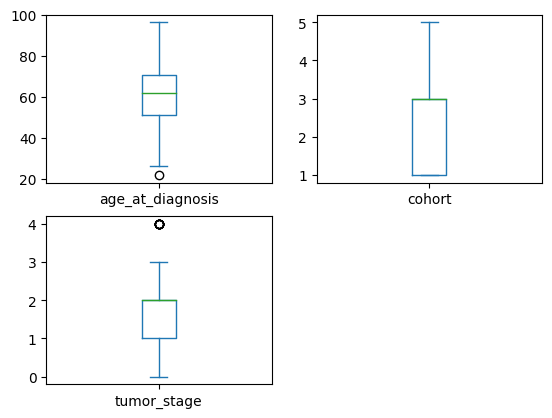

In [4]:
# b) Data visualizations

# Box and Whisker Plots of a few features
raw_plot = pd.DataFrame(raw_data, columns=["age_at_diagnosis", "cohort", "cellularity", "tumor_stage"])
raw_plot.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
plt.show()

cellularity    AxesSubplot(0.125,0.712609;0.168478x0.167391)
dtype: object

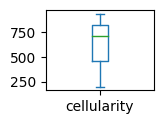

In [5]:
# Box plot for a categorial data
raw_plot['cellularity'].value_counts().plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False)

### 3. Prepare Data

In [6]:
# a) Data Cleaning
# Drop useless columns
to_keep = [i for i in range(0, 519)]
data = pd.read_csv('METABRIC_RNA_Mutation.csv', header=0, usecols=to_keep)
print(data.shape)

(1904, 519)


By doppring unimportant columns, the number of features reduces from 693 to 519.

In [7]:
# Define class for the classification class "death_from_cancer"
data['death_from_cancer'].replace({'Living': 0, 'Died of Other Causes': 1, 'Died of Disease': 2}, inplace=True)

Removing outliers in numerical columns is a mandatory step to aid the training and validation process. Here I do it by calculating the correlation between these variables with the target variables, identifying low correlation columns, and filtering values less than the lower and greater than the upper bounds.

In [8]:
# calculate the correlation between numerical columns and target variable
corr_matrix = data.select_dtypes(include=np.number).corrwith(data['death_from_cancer']).sort_values(ascending=False)

# filter columns with low correlation 
corr_threshold = 0.05
low_corr_columns = corr_matrix[corr_matrix.abs() < corr_threshold].index

# remove outliers from numerical columns with low correlation
for column in low_corr_columns:
    lower = data[column].quantile(0.01)
    upper = data[column].quantile(0.99)
    data[column] = data[column].clip(lower, upper)

In [9]:
# Identify columns with missing values and count the number of missing values
null_cols = data.columns[data.isnull().any()]
null_count = data[null_cols].isnull().sum()

print(null_count)

type_of_breast_surgery             22
cancer_type_detailed               15
cellularity                        54
er_status_measured_by_ihc          30
neoplasm_histologic_grade          72
tumor_other_histologic_subtype     15
primary_tumor_laterality          106
mutation_count                     45
oncotree_code                      15
3-gene_classifier_subtype         204
tumor_size                         20
tumor_stage                       501
death_from_cancer                   1
dtype: int64


In [10]:
# Imputation of missing values with 'mode' values in important columns
cols_to_fill = ["type_of_breast_surgery", "cancer_type_detailed", "cellularity", "er_status_measured_by_ihc", 
                "neoplasm_histologic_grade", "tumor_other_histologic_subtype", "primary_tumor_laterality", 
                "mutation_count", "3-gene_classifier_subtype", "tumor_size", "tumor_stage"]
for col in cols_to_fill:
    data[col] = data[col].fillna(data[col].mode()[0])

In [11]:
df = data.copy(deep = True)

# Convert strings into categorial classes
cols_to_convert = ["type_of_breast_surgery", "cellularity", "er_status_measured_by_ihc", "her2_status",
                 "inferred_menopausal_state","pr_status"]

replace_dict = {"type_of_breast_surgery": {'BREAST CONSERVING': 1, 'MASTECTOMY': 0},
                "cellularity": {'High': 2, 'Moderate': 1, 'Low': 0},
                "er_status_measured_by_ihc": {'Positve': 1, 'Negative': 0},
                "her2_status": {'Positive': 1, 'Negative': 0},
                "inferred_menopausal_state": {'Post': 1, 'Pre': 0},
                "pr_status": {'Positive': 1, 'Negative': 0}}

for col in cols_to_convert:
    df[col].replace(replace_dict[col], inplace=True)

In [12]:
#Use One Hot Encoding to convert categorical features into numeric features

df = pd.get_dummies(data = df, columns = ['cancer_type','cancer_type_detailed', 'er_status', 'her2_status_measured_by_snp6', 'pam50_+_claudin-low_subtype','tumor_other_histologic_subtype', 'integrative_cluster', 'primary_tumor_laterality', '3-gene_classifier_subtype'])

In [13]:
# drop rows with missing values
df.dropna(inplace=True)
print(df.shape)

(1888, 556)


In [14]:
# b) Feature Selection
# Select the top k most relevant features (largest values)
def select_features(X, y, features):
# configure to select all features
    fs = SelectKBest(score_func=f_classif, k=10)
    
# learn relationship from training data
    fs.fit(X, y)
    
    df_scores = pd.DataFrame(fs.scores_)
    df_columns = pd.DataFrame(X.columns)
    
    feature_scores = pd.concat([df_columns,df_scores], axis=1)
    feature_scores.columns = ['fname','score']
    
    best_features = feature_scores.nlargest(features,'score')
    
    X_featured = pd.DataFrame()  
    for j in best_features['fname']:
        X_featured[j] = X[j]

    X = X_featured.copy()
    X = np.array(X)    
    y = np.array(y)
    
    # plot feature scores
    a = best_features['fname']
    b= best_features['score']    
    plt.bar(a, b)
    plt.xticks(rotation=45, ha='right')
    plt.show()
    return X, y, fs

/home/haziqfaiz/.local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


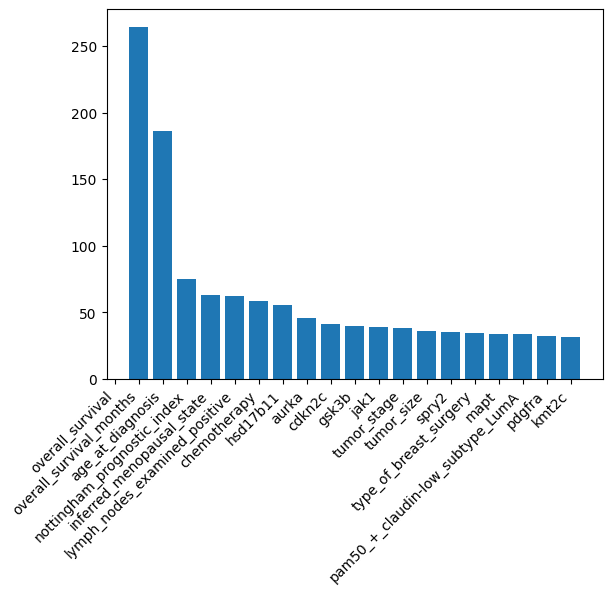

In [15]:
# c) Split the dataset into train and test sets 
X = df.drop(columns=['death_from_cancer', 'patient_id', 'oncotree_code'], axis = 1)
y = df['death_from_cancer']

X, y, fs = select_features(X, y, 20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

The chart clearly shows that 2 features (overall_survival and overall_survival_months) might be the most relevant variables.

In [16]:
# c) Data Transforms
# Standardize the dataset by rescaling the distribution of values
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# convert the array back to a dataframe
X_train = DataFrame(X_train)
X_test = DataFrame(X_test)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1416, 20) (472, 20)
(1416,) (472,)


### 4. Evaluate Algorithms

In this section, I used XGBoost and Keras neural network model for the training and validation processes.

In [22]:
# a) Ensemble algorithm (XGBoost)
# Define model
model1 = XGBClassifier(use_label_encoder=False)

# Use DMatrix to convert input data into internal data structure that is optimized for both memory efficiency and training speed.
df_xgb = xgb.DMatrix(data=X, label=y)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3)

model1.fit(X_train1, y_train1)

# make predictions for test data
pred = model1.predict(X_test1)

# evaluate predictions
accuracy = accuracy_score(y_test1, pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

/home/haziqfaiz/.local/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Accuracy: 83.77%


The training accuracy of the XGBoostClassifier with default parameters is fairly decent and is within the range of the standard ML and ensemble algorithms in Notebook 1.

In [24]:
# b) Deep learning model (Keras Sequential)
# Define a model with 3 layers and dropout regulation
NN_model = keras.Sequential([    
    keras.layers.Dense(300, input_shape = (20, ), activation = 'relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(150, activation = 'relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1, activation='softplus')  
])

NN_model.compile(optimizer = 'adam',
                loss = 'mean_squared_logarithmic_error',
                metrics=['mse'])

The use of squared error as a loss function for classification was studied by Hui and Belkin (2020).

"We argue that there is little compelling empirical or theoretical evidence indicating a clear-cut advantage to the cross-entropy loss. Indeed, in our experiments, performance on nearly all non-vision tasks can be improved, sometimes significantly, by switching to the square loss. Furthermore, training with square loss appears to be less sensitive to the randomness in initialization. We posit that training using the square loss for classification needs to be a part of best practices of modern deep learning on equal footing with cross-entropy."

In [25]:
# fit the keras model on the dataset
model_fit = NN_model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=50, batch_size=64)

Epoch 1/50
23/23 [==============================] - 1s 8ms/step - loss: 0.1192 - mse: 0.4481 - val_loss: 0.0400 - val_mse: 0.1851
Epoch 2/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0430 - mse: 0.2409 - val_loss: 0.0239 - val_mse: 0.1443
Epoch 3/50
23/23 [==============================] - 0s 4ms/step - loss: 0.0287 - mse: 0.1707 - val_loss: 0.0222 - val_mse: 0.1288
Epoch 4/50
23/23 [==============================] - 0s 4ms/step - loss: 0.0266 - mse: 0.1560 - val_loss: 0.0213 - val_mse: 0.1254
Epoch 5/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0237 - mse: 0.1429 - val_loss: 0.0203 - val_mse: 0.1249
Epoch 6/50
23/23 [==============================] - 0s 4ms/step - loss: 0.0231 - mse: 0.1427 - val_loss: 0.0205 - val_mse: 0.1238
Epoch 7/50
23/23 [==============================] - 0s 4ms/step - loss: 0.0213 - mse: 0.1317 - val_loss: 0.0201 - val_mse: 0.1233
Epoch 8/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0208 - mse: 0.12

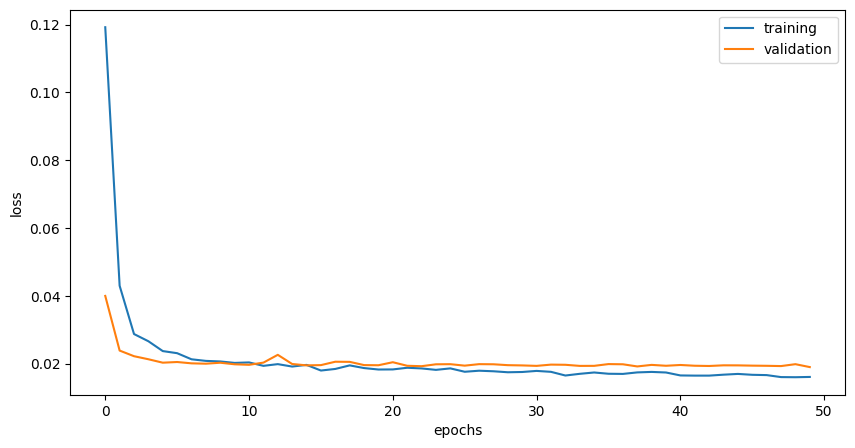

In [26]:
# Plot learning curve
plt.figure(figsize = (10, 5))
plt.plot(model_fit.history['loss'], label = 'training')
plt.plot(model_fit.history['val_loss'], label = 'validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

Overall, the training and validation performances of this Keras Sequential model is in good agreement. However, the loss values over 50 epoches are very good (~0.01) meaning it is ready for prediction.

### 5. Improve Accuracy

In [22]:
# Algorithm (XGBoost) Tuning
# Define model
model_XGB = XGBClassifier(use_label_encoder=False)

In [23]:
# Sensitivity parameters
# Tuning Learning Rate and the Number of Trees
lrate = [0.001, 0.01, 0.1]
n_tree = [100, 300, 500]
param_grid = dict(learning_rate=lrate, n_estimators=n_tree)

# Grid search on optimum hyperparameters for XGBooost model
model_XGB_temp = GridSearchCV(estimator=model_XGB, param_grid=param_grid, scoring="neg_log_loss", verbose=1)
grid_result = model_XGB_temp.fit(X_train1, y_train1, eval_metric='rmse')
print("Optimum parameters %s" % (grid_result.best_params_))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Optimum parameters {'learning_rate': 0.01, 'n_estimators': 500}


Now we will implement these optimum parameters to retrain and validate the dataset.

### 6. Finalize Model

In [24]:
# a) Predictions on validation dataset
# Define XGBoost model with optimum set of parameters
model_XGB = XGBClassifier(learning_rate = 0.01, n_estimators = 500, use_label_encoder=False)

# Fit the trained model to the valiation data
fit_XGB = model_XGB.fit(X_train1, y_train1)

# estimate accuracy on validation dataset
fit_XGB.score(X_test1, y_test1)
pred = fit_XGB.predict(X_test1)

# Let's see the accuracy score
accuracy = accuracy_score(y_test1, pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[18:28:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 83.07%


In [25]:
# Evaluate the keras model on the test set
test_loss, test_acc = NN_model.evaluate(X_test, y_test)
print('Test loss:', test_loss)

15/15 [==============================] - 0s 3ms/step - loss: 0.0201 - mse: 0.1286
Test loss: 0.02010841853916645


Tuning XGBoost model parameters lift the accuracy slightly from 82.54% to 83.07% but still within the range of standard and ensemble ML algorithms.

The Keras model performs better than the XGBoost model with fairly low loss value of 0.01. 

In [26]:
# b) Save model for later use
# save the model to disk
filename = 'finalized_model.sav'
dump(model_XGB, open(filename, 'wb'))

### 7. Conclusions

- Staring with the problem statement, we performed exploratory data analysis and cleaning before passing the data into algorithms for training and prediction.


- Exploratory data analysis and data cleaning are crucial steps in this complex dataset to ensure achieving good training and validation performance.


- The ensemble algorithm (XGBoost) with default parameters has a prediction accuracy of 82.54% which is within the range of ML and ensemble algorithms in Notebook 1. Further tuning of the model's parameters (learning rate and tree number) improves its performance slightly to 83.07%.


- The performance of the neural network model (Keras Sequential) with 3 layers and dropput regulation seems to be comparable to the XGBoost model. Loss values of training and validation are in good agreement and achieved excellent mean squared error of 0.1.


- Predictive performances of all ML and deep learning algorithms on this dataset are very good with the accuracy over 80%.